# Neural Optimal Transport (NOT) for Strong Costs [Seminar]
The seminar is prepared by [Alexander Korotin](https://scholar.google.ru/citations?user=1rIIvjAAAAAJ). This is a stand-alone Google Colab implementation (pytorch). Both CPU & GPU supported.

**Terms of use.** I give my permission to use this seminar for educational purposes but only "as is", i.e., without any changes. If you have found a misprint/mistake or have a suggestion regarding improving the seminar, please leave a comment in the repository.

In this seminar, you will learn how to:
- [Theoretical part] Derive the duality formula for strong transport costs;
- [Practical part] Implement [NOT algorithm](https://arxiv.org/abs/2201.12220) for strong costs:
  - On toy 2D examples;
  - On a simple unpaired image-to-image translation task;

**Related works** and **repositories** to consider:
  - *Neural Optimal Transport* [paper](https://arxiv.org/abs/2201.12220) and [github](https://github.com/iamalexkorotin/NeuralOptimalTransport) (ICLR 2023 spotlight);
  - *Kernel Neural Optimal Transport* [paper](https://arxiv.org/abs/2205.15269) (ICLR 2023);
  - *Do Neural Optimal Transport Solvers work? A Continuous Wasserstein-2 Benchmark* [paper](https://openreview.net/forum?id=CI0T_3l-n1) and [github](https://github.com/iamalexkorotin/Wasserstein2Benchmark) (NeurIPS 2021);
  - *Generative modeling with optimal transport maps* [paper](https://openreview.net/forum?id=5JdLZg346Lw) and [github](https://github.com/LituRout/OptimalTransportModeling) (ICLR 2022);
  - *An Optimal Transport Perspective on Unpaired Image Super-Resolution* [paper](https://arxiv.org/abs/2202.01116).
  - *Kantorovich Strikes Back! Wasserstein GANs are not Optimal Transport?* [paper](https://arxiv.org/abs/2206.07767) and [github](https://github.com/justkolesov/Wasserstein1Benchmark) (NeurIPS 2022).

## 0. Warmup part. Monge's OT formulation

For a pair of probability distributions $\mathbb{P}, \mathbb{Q}$ on spaces $\mathcal{X}$, $\mathcal{Y}$, respectively, and a cost function $c:\mathcal{X}\times\mathcal{Y}\rightarrow \mathbb{R}$, the Monge formulation of OT is
$$\text{Cost}(\mathbb{P},\mathbb{Q})=\inf_{{\color{blue}T}\sharp\mathbb{P}=\mathbb{Q}}\int_{\mathcal{X}}c\big(x,{\color{blue}T}(x)\big)d\mathbb{P}(x),$$
where the $\inf$ is taken over the functions ${\color{blue}T}:\mathcal{X}\rightarrow\mathcal{Y}$ transforming $\mathbb{P}$ to $\mathbb{Q}$ (transport maps). For example, $\mathcal{X}=\mathcal{Y}=\mathbb{R}^{D}$, $c(x,y)=\frac{1}{2}\|x-y\|^{2}$.

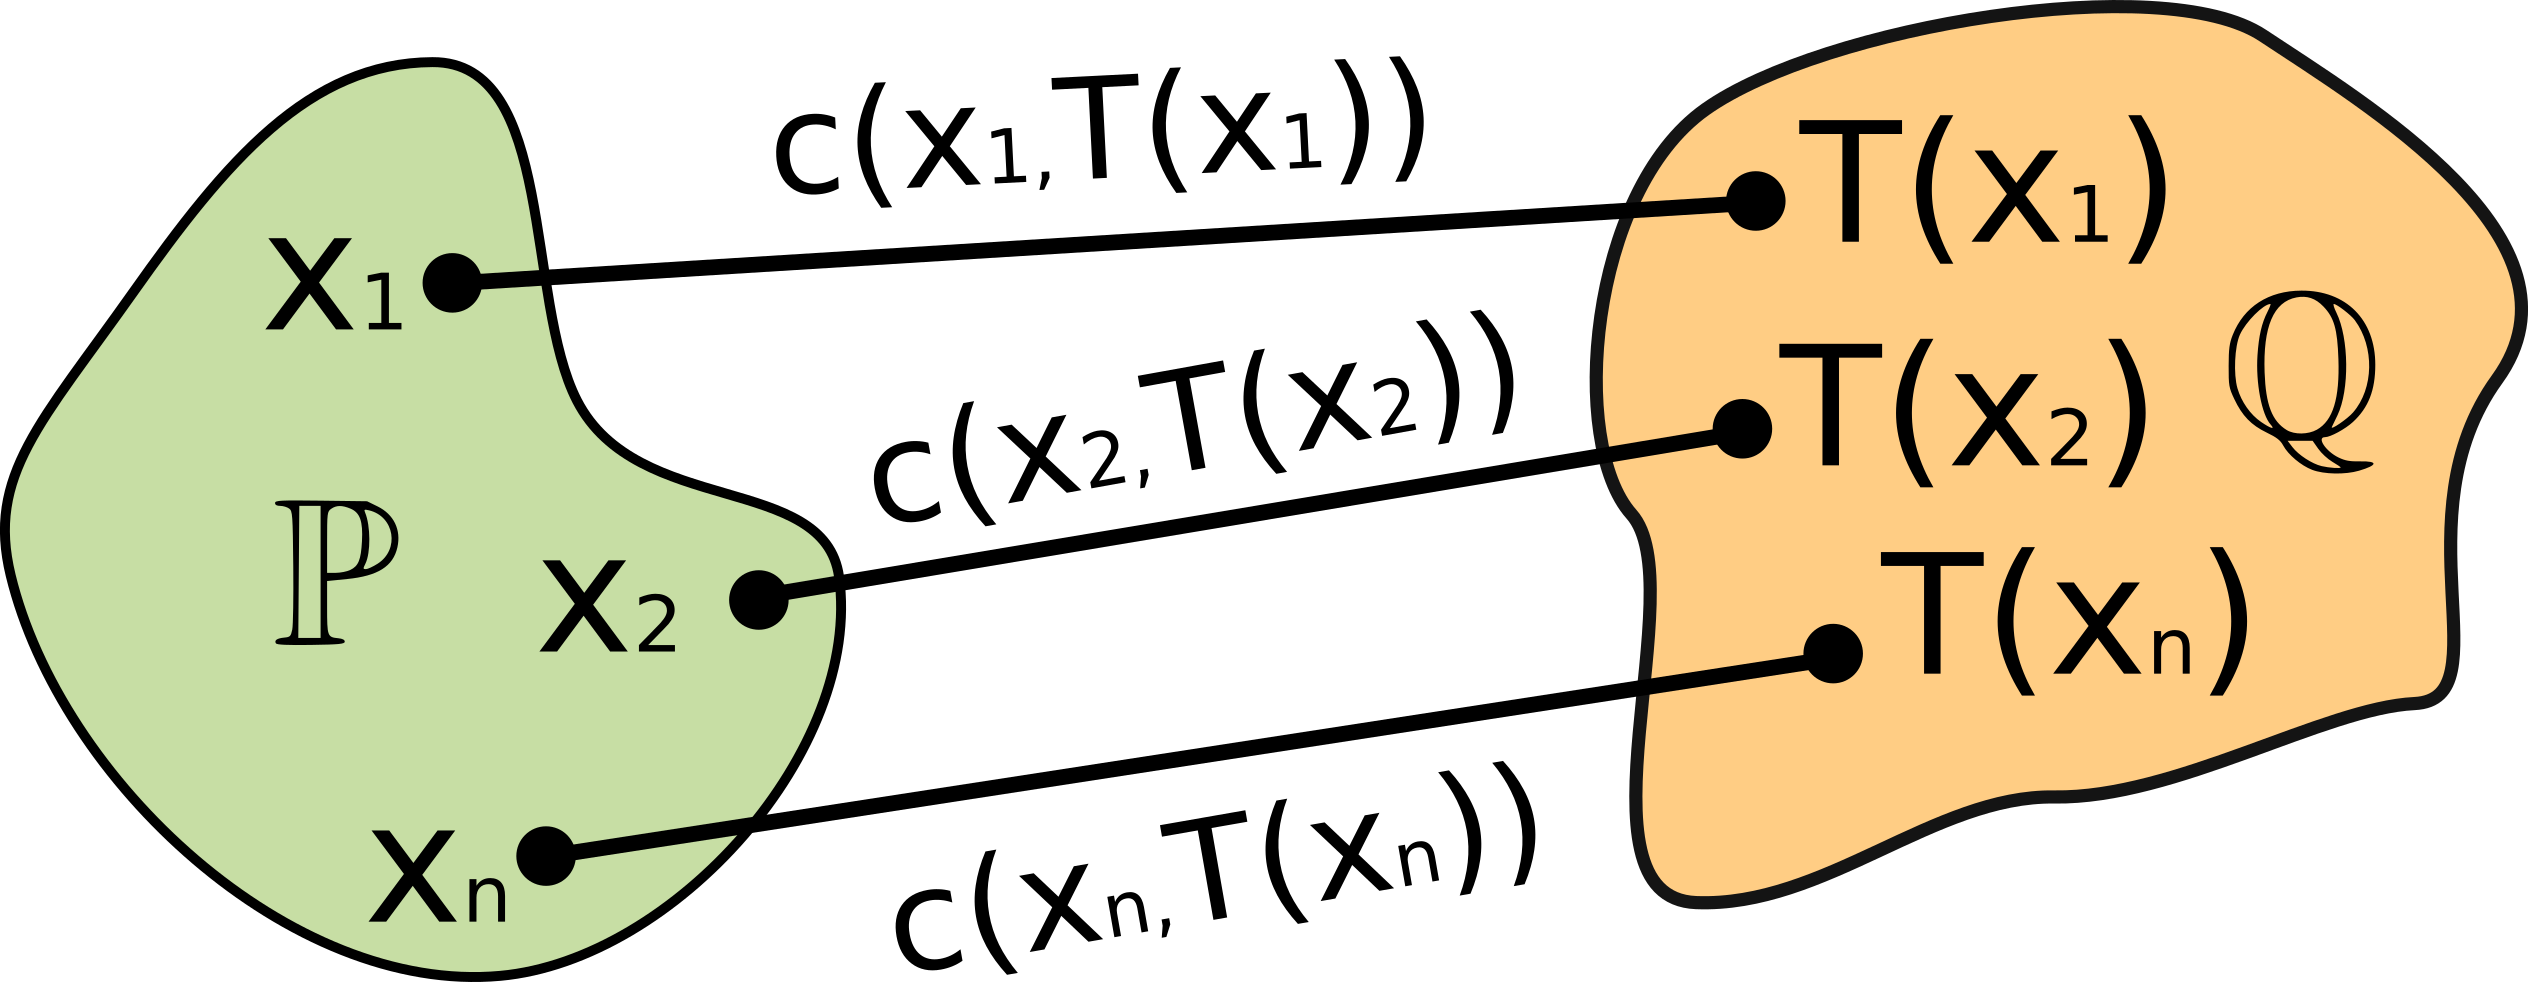

The (*alternative*/*semi-dual*/*maximin*/*expanded*) dual OT form which is needed for the NOT algorithm is given by
$$\text{Cost}(\mathbb{P},\mathbb{Q})=\sup_{{\color{red}f}}\inf_{{\color{blue}T}}\underbrace{\big[\int_{\mathcal{X}}c\big(x,{\color{blue}T}(x)\big)d\mathbb{P}(x)-\int_{\mathcal{X}}{\color{red}f}\big({\color{blue}T}(x)\big)d\mathbb{P}(x)+\int_{\mathcal{Y}}{\color{red}f}(y)d\mathbb{Q}(y)\big]}_{\stackrel{def}{=}\mathcal{L}({\color{red}f},{\color{blue}T})},$$
where the $\sup_{\color{red}f}$ is taken over functions ${\color{red}f}:\mathcal{Y}\rightarrow \mathbb{R}$ (potentials). In the two following parts of the seminar, we will derive this dual form and implement the NOT algorithm which optimizes it with neural nets and recovers an saddle point $({\color{red}f^{*}},{\color{blue}T^{*}})$.

⚠️ <font color='red'>**Warning!**</font> One might claim that this form is similar to the Wasserstein GAN loss (two second terms containing ${\color{red}f}$) plus an additional transport cost term (the first term with $c$). However, it is absolutely not related to WGANs, see the list of differences in Table 1 of [this paper](https://arxiv.org/pdf/2202.01116.pdf).

## 1. Theoretical part. Derivation of the duality for strong costs
Here we derive a very short ideological proof of the alternative duality formula needed for NOT. The provided proof is insiped by the awesome [book](http://math.univ-lyon1.fr/~santambrogio/OTAM-cvgmt.pdf) by Santambrogio (see Section 1.2). As the goal of this section is to give the general intuition (we will not be very mathematically rigorous).

We consider the Monge formulation of OT. It is an optimization problem with the constraint ${\color{blue}T}\sharp \mathbb{P}=\mathbb{Q}$. We derive its dual form in 3 steps.

**Step 1 [Indicator function].** For two distrubtions $\mathbb{Q}_{1},\mathbb{Q}_{2}$ on $\mathcal{Y}$ we note that
$$I_{\mathbb{Q}_1,\mathbb{Q}_2}\stackrel{def}{=}\sup_{{\color{red}f}}\big[\int_{\mathcal{Y}}{\color{red}f}(y)d\mathbb{Q}_{2}(y)-\int_{\mathcal{Y}}{\color{red}f}(y)d\mathbb{Q}_{1}(y)\big]=\begin{cases}
			0, & \text{if }\mathbb{Q}_1=\mathbb{Q}_2\\
            +\infty, & \text{otherwise}
		 \end{cases}.$$

⚠️ <font color='red'> **Warning!**</font> Again! This is *not* related to WGANs. The feasible set of ${\color{red}f}$ here is <font color='green'>unconstrained</font> and does not require $1$-Lipschitz continuity.

**Step 2 [Removing the constraints].** We incorporate the constraints (e.g, see the [duality gap](https://en.wikipedia.org/wiki/Duality_gap) page) into the Monge problem and make it unconstrained via adding $I_{T\sharp\mathbb{P},\mathbb{Q}}$:
$$\text{Cost}(\mathbb{P},\mathbb{Q})=\inf_{{\color{blue}T}\sharp\mathbb{P}=\mathbb{Q}}\int_{\mathcal{X}}c\big(x,{\color{blue}T}(x)\big)d\mathbb{P}(x)=\inf_{{\color{blue}T}}\big[\int_{\mathcal{X}}c\big(x,{\color{blue}T}(x)\big)d\mathbb{P}(x)+I_{{\color{blue}T}\sharp\mathbb{P},\mathbb{Q}}\big]$$
The problems are indeed equivalent: if in the right problem ${\color{blue}T}\sharp\mathbb{P}\neq\mathbb{Q}$, then the expession inside $\inf_{{\color{blue}T}}$ equals $+\infty$.

**Step 3 [Swapping inf and sup].** If we expand $I_{T\sharp\mathbb{P},\mathbb{Q}}$ in the step 2 and use the [change of variables](https://en.wikipedia.org/wiki/Pushforward_measure) for ${\color{blue}T}\sharp\mathbb{P}$, we obtain
$$\text{Cost}(\mathbb{P},\mathbb{Q})=\inf_{{\color{blue}T}}\sup_{f}\big[\int_{\mathcal{X}}c\big(x,{\color{blue}T}(x)\big)d\mathbb{P}(x)-\int_{\mathcal{X}}{\color{red}f}\big({\color{blue}T}(x)\big)d\mathbb{P}(x)+\int_{\mathcal{Y}}{\color{red}f}(y)d\mathbb{Q}(y)\big]=\inf_{{\color{blue}T}}\sup_{{\color{red}f}}\mathcal{L}({\color{red}f},{\color{blue}T})=\sup_{{\color{red}f}}\inf_{{\color{blue}T}}\mathcal{L}({\color{red}f},{\color{blue}T}).$$
The last thing is to swap $\inf$ and $\sup$ (the last equality) by using the [minimax theorem](https://doducthao.github.io/assets/dl_posts/gan/simons1995.pdf) to obtain the desired duality formula. $\square$

❔ Let us analyse the derived formula. To better understand the derivations, try to answer the following questions:
- Why do we need swap $\inf_{{\color{blue}T}}$ and $\sup_{{\color{red}f}}$? Why $\inf_{{\color{blue}T}}\sup_{{\color{red}f}}$ is not a very good optimization problem from the theoretical point of view?
- What is the meaning of the function ${\color{red}f}$ (Kantorovich potential)? **Hint:** Recall the Lagrange multiplier method.

⚠️ <font color='red'> **Warning!**</font> The proof is **not complete**. The omitted detail is checking that the assumptions of the minimax theorem hold. Common minimax theorems require $\mathcal{L}({\color{red}f},{\color{blue}T})$ to be convex in ${\color{blue}T}$ and concave in ${\color{red}f}$. In our case, the second requirement indeed holds: $\mathcal{L}({\color{red}f},{\color{blue}T})$ is concave (even linear) in ${\color{red}f}$ for a fixed ${\color{blue}T}$. However, for a fixed ${\color{red}f}$, the functional is not convex in ${\color{blue}T}$. Nevertheless, the duality formula still holds, i.e., $\inf_{{\color{blue}T}}$ and $\sup_{{\color{red}f}}$ can be swapped (in this particular case)! For now we accept the given duality formula as true and get back to this question during the next seminar.

💡 **Hint:** You may derive the duality formula from the Kantorovich OT formulation. Kantorovich's form replaces non-convex optimization over functions ${\color{blue}T}$ with the convex (even linear) optimization over plans ${\color{blue}\pi}$ allowing to employ the minimax theorem.

## 2. Practical part. Learning optimal maps with neural nets

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

import random
import numpy as np

import torch
import torch.nn as nn

import torchvision.datasets as datasets
from torchvision import transforms

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### 2.1. Toy 2D example (fully connected neural networks)
We are going train a neural net to optimally map the 2D standard Gaussian to a Gaussian mixture. Let us take a look at this pair of distributions.

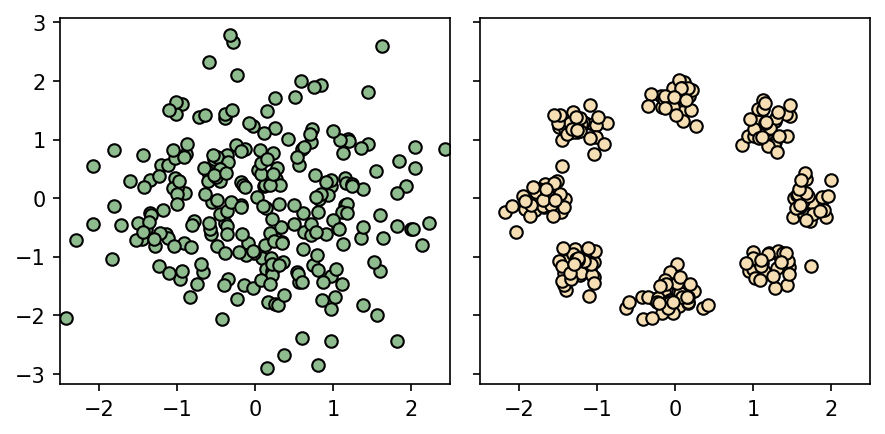

In [2]:
# Use these functions to sample from the distributions

def sample_normal(size=64):
  return np.random.normal(size=(size,2)).astype(np.float32)

def sample_mixture(size=64):
  centers = np.array([(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
             (1./np.sqrt(2), -1./np.sqrt(2)), (-1./np.sqrt(2), 1./np.sqrt(2)),
             (-1./np.sqrt(2), -1./np.sqrt(2))])
  batch = np.random.normal(size=(size,2)).astype(np.float32) * 0.2
  indices = random.choices(range(len(centers)), k=size)
  batch += 1.7 * centers[indices, :]
  return batch

X = sample_normal(256)
Y = sample_mixture(256)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=150, sharex=True, sharey=True)
axes[0].scatter(X[:,0], X[:, 1], c='darkseagreen', edgecolors='black')
axes[1].scatter(Y[:,0], Y[:, 1], c='wheat', edgecolors='black')
axes[0].set_xlim(-2.5, 2.5); axes[1].set_xlim(-2.5, 2.5)
fig.tight_layout()

Now let us choose a strong transport cost. To begin with, we will use the **quadratic cost** (normalized by the dimension, i.e., mean squared error):


In [3]:
def sq_cost (X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

COST = sq_cost

Define the networks for the transport map ${\color{blue}T}:\mathbb{R}^{2}\rightarrow \mathbb{R}^{2}$ (generator) and potential ${\color{red}f}:\mathbb{R}^{2}\rightarrow \mathbb{R}$ (discriminator). It sufficies to use medium-size multi-layer perceptrons for ${\color{blue}T},{\color{red}f}$ with ReLU activations.

In [ ]:
T = nn.Sequential(
    # <<< your code here >>>
).to(DEVICE)

f = nn.Sequential(
    # <<< your code here >>>
).to(DEVICE)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 33666
f params: 33537


Define the optimizers for ${\color{blue}T}, {\color{red}f}$ (Adam is recommended):

In [ ]:
T_opt = # <<< your code here >>>
f_opt = # <<< your code here >>>

Now implement NOT algorithm for strong costs (Algorithm 1 in [this paper](https://arxiv.org/abs/2202.01116)) and train the networks:

<img width=600 src=" 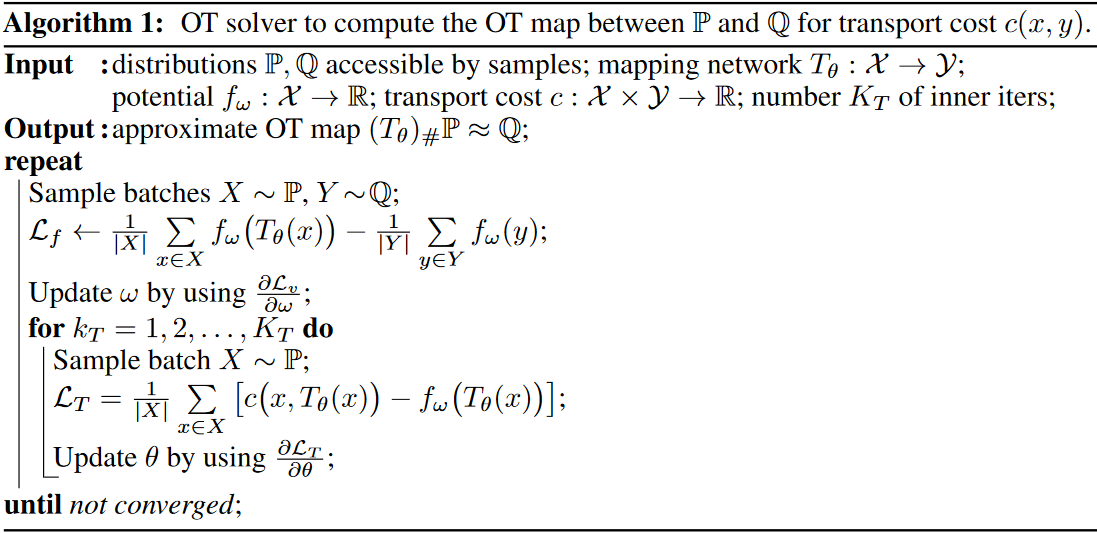">

In [ ]:
# Fixed samples for plotting
X_fixed, Y_fixed = sample_normal(256), sample_mixture(256)

# Parameters
T_ITERS = 10 # how much T updates to do per 1 update of 
MAX_STEPS = 4000 # total number of training steps

Step 3800


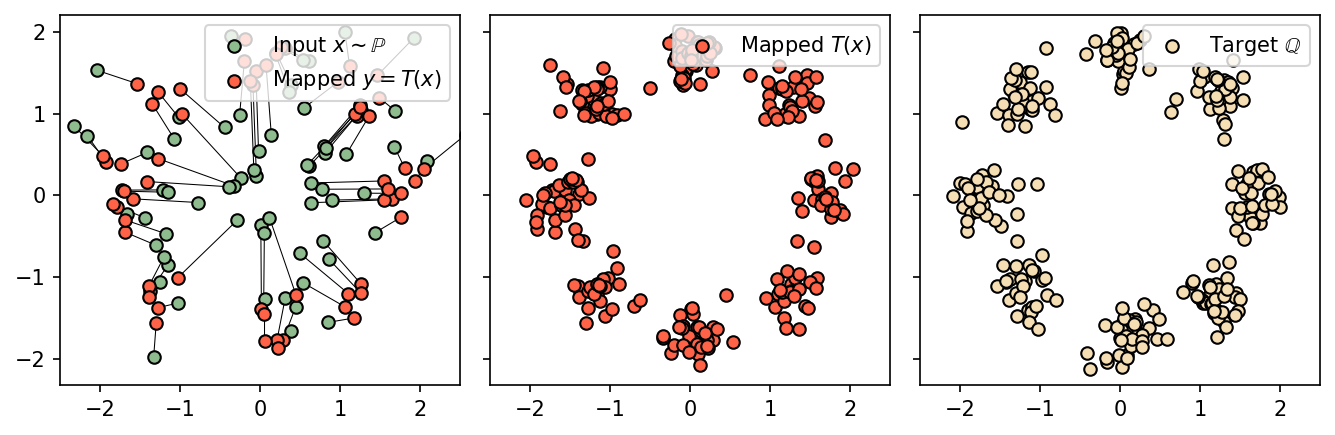

In [ ]:
# NOT algorithm
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    T.train(True); f.eval()
    for t_iter in range(T_ITERS):
        X = # <<< your code here >>>
        T_loss = # <<< your code here >>>
        T_opt.zero_grad(); T_loss.backward(); T_opt.step()

    # f optimization
    T.eval(); f.train(True)
    X, Y = # <<< your code here >>>
    f_loss = # <<< your code here >>>
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    if step % 200 == 0:
        clear_output(wait=True)
        print("Step", step)

        # The code for plotting the results
        fig, axes = plt.subplots(1, 3, figsize=(9,3), dpi=150, sharex=True, sharey=True)
        X_fixed = torch.tensor(X_fixed, device=DEVICE)
        with torch.no_grad():
            T_X_fixed = T(X_fixed).to('cpu').numpy()
            X_fixed = X_fixed.to('cpu').numpy()
        lines =  list(zip(X_fixed[:64], T_X_fixed[:64]))
        lc = mc.LineCollection(lines, linewidths=0.5, color='black')
        axes[0].add_collection(lc)

        axes[0].scatter(X_fixed[:64,0], X_fixed[:64, 1], c='darkseagreen', edgecolors='black', zorder=2, label=r'Input $x\sim\mathbb{P}$')
        axes[0].scatter(T_X_fixed[:64,0], T_X_fixed[:64, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')
        axes[1].scatter(T_X_fixed[:,0], T_X_fixed[:, 1], c='tomato', edgecolors='black', label=r'Mapped $T(x)$')
        axes[2].scatter(Y_fixed[:,0], Y_fixed[:, 1], c='wheat', edgecolors='black', label=r'Target $\mathbb{Q}$')
        axes[0].legend(loc='upper right'); axes[1].legend(loc='upper right'); axes[2].legend(loc='upper right')
        axes[0].set_xlim(-2.5, 2.5); axes[0].set_xlim(-2.5, 2.5)
        fig.tight_layout(); plt.show()

❔ Take a look at the obtained map ${\color{blue}T}:\mathbb{R}^{2}\rightarrow \mathbb{R}^{2}$. Does it have some nice structure? How do you judge that the learned map is optimal?

💡 **Hint.** The segments $[x,{\color{blue}T}(x)]$ will not intersect for different $x$. Thus, the OT map can be used to perform a geometricall meaningful interpolation between probability distributions (**cycle monotonity** property, see Section 5 in the [book](https://cedricvillani.org/sites/dev/files/old_images/2012/08/preprint-1.pdf) by Villani).

Now consider different transport costs, train NOT
 and see how changing the cost affects the learned OT map:
- 👍 $c(x,y)=53\cdot \|x-y\|^{2}+17.2$ - scaling/translation **DOES NOT** affect the OT map (think why!);
- 👍 $c(x,y)=-2x^{\top}y$ - again, nothing changes (think why or see Case 5.17 [here](https://cedricvillani.org/sites/dev/files/old_images/2012/08/preprint-1.pdf));
- 👍 $c(x,y)=\|x+y\|_{2}^{2}$ - segments should start to intersect;
- 👎 $c(x,y)=\|x-y\|_{2}$ - mode collapse;
- 👎 $c(x,y)=0$ - divergence/fluctuation;

The latter two costs recover ${\color{blue}T}$ which is not necessarily the OT map (👎). This happens due to existence of **fake solutions**, i.e., optimal pairs $({\color{red}f}^{*},{\color{blue}T}^{*})$ in which ${\color{blue}T}^{*}$ is not an OT map. Fake solutions may exist even for the first three costs (👍) but seem not to be a problem in practice.

🔎 **Remark.** We are not going to discuss the issue with fake solutions in this seminar. If you want to dig deeper, consider the [Kernel NOT](https://arxiv.org/abs/2205.15269) paper which studies fake solutions for a more general OT formulation (weak OT) which deserves a separate seminar.

### 2.2. Unpaired image-to-image translation (convolutional neural networks)
We are going to apply the NOT algorithm to learn the OT map for an unpaired image-to-image translation problem. We have access (via the empirical samples - datasets) to a pair of image distributions $\mathbb{P},\mathbb{Q}$. We aim to find a (one-sided) *image-to-image translation* map ${\color{blue}T}:\mathcal{X}\rightarrow\mathcal{Y}$ which transforms samples from the distribution $\mathbb{P}$ to $\mathbb{Q}$.

<img width=400 src=" 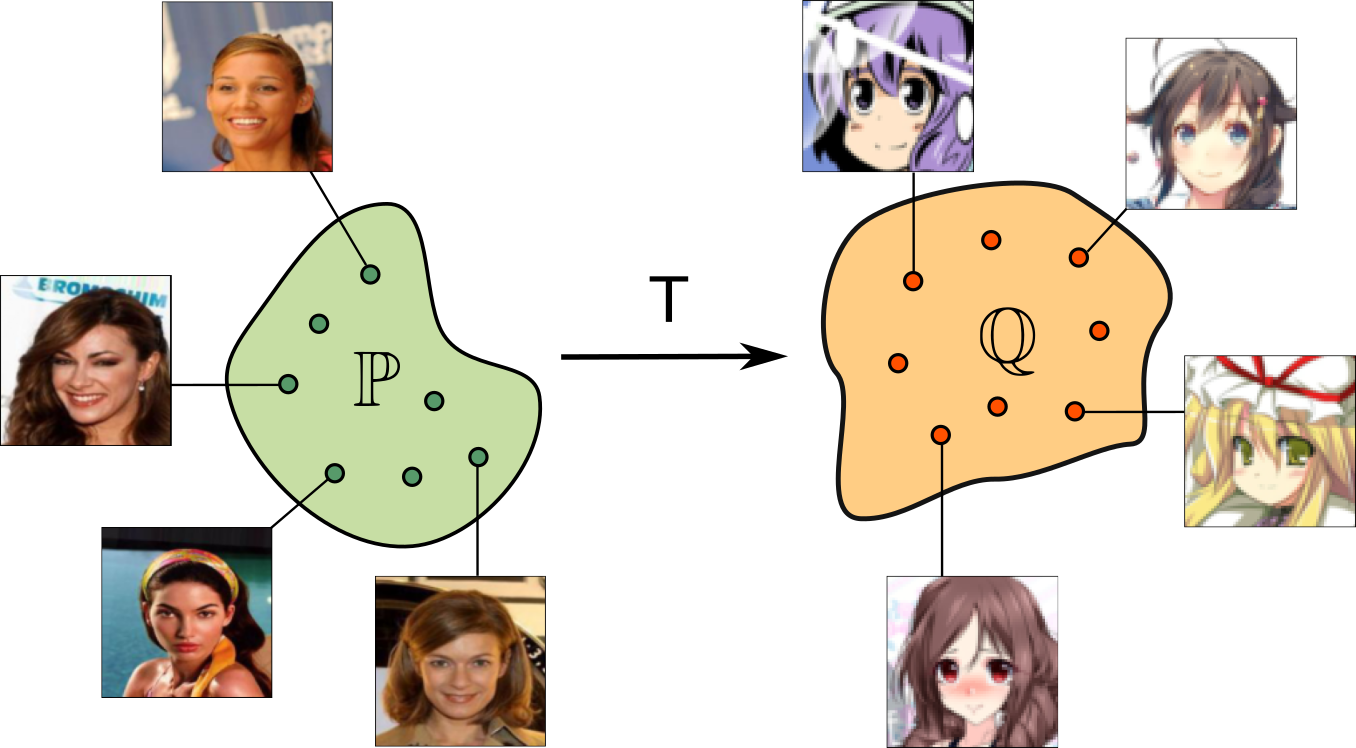">

In many such problems, it is reasonable to use an OT map as the translation map as it aims to maximally preserve the input content. For an extended discussion, see Section 5.2 in [NOT paper](https://arxiv.org/abs/2201.12220). To keep the seminar simple, we consider $16\times 16$ colorized **MNIST** & **USPS** digit datasets and learn an OT map between them.

In [5]:
BATCH_SIZE = 64

def random_color(im):
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

TRANSFORM = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    transforms.Normalize([0.5],[0.5])
])

# Load train datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM)
usps_train = datasets.USPS(root='./data', train=True, download=True, transform=TRANSFORM)

mnist_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
usps_loader = torch.utils.data.DataLoader(usps_train, batch_size=BATCH_SIZE, shuffle=True)

# Load test datasets
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM)
usps_test = datasets.USPS(root='./data', train=False, download=True, transform=TRANSFORM)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE)
usps_test_loader = torch.utils.data.DataLoader(usps_test, batch_size=BATCH_SIZE)

# We only a few samples from them for the qualitative analysis
X_test_fixed = next(iter(mnist_test_loader))[0]
Y_test_fixed = next(iter(usps_test_loader))[0]

del mnist_test_loader, usps_test_loader, mnist_test, usps_test

Let us take a look at the images from the datasets.

Random (unpaired) images from MNIST (1st row) and USPS (2nd row) train sets


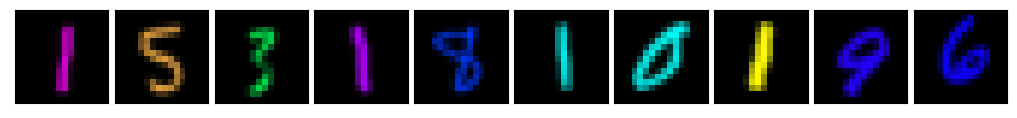

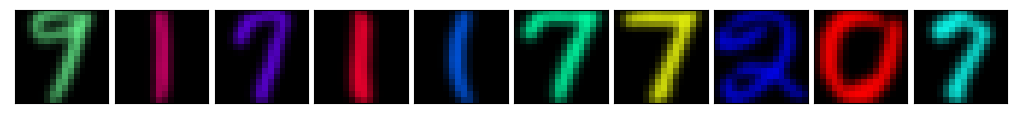

In [8]:
def plot_images(batch):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1), dpi=100)
    for i in range(10):
        axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
        axes[i].set_xticks([]); axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)

print('Random (unpaired) images from MNIST (1st row) and USPS (2nd row) train sets')
plot_images(next(iter(mnist_loader))[0])
plot_images(next(iter(usps_loader))[0])

The code below can be used to sample batches from the datasets.

In [9]:
iter_mnist, iter_usps = iter(mnist_loader), iter(usps_loader)

def sample_mnist():
    global iter_mnist, mnist_loader
    try:
        return next(iter_mnist)[0]
    except StopIteration:
        iter_mnist = iter(mnist_loader)
        return next(iter_mnist)[0]

def sample_usps():
    global iter_usps, usps_loader
    try:
        return next(iter_usps)[0]
    except StopIteration:
        iter_usps = iter(usps_loader)
        return next(iter_usps)[0]

As in the toy 2D case, define the networks for transport map ${\color{blue}T}:\mathbb{R}^{3\times 16\times 16} \rightarrow \mathbb{R}^{3\times 16\times 16}$ and potential ${\color{red}f}:\mathbb{R}^{3\times 16\times 16}\rightarrow \mathbb{R}$. It sufficies to construct sequential convolutional networks with LeakyReLU non-linearities, MaxPool/AvgPool, Batchnorm. Define the optimizers for them.

In [10]:
T = nn.Sequential(
    # <<< your code here >>>
).to(DEVICE)

f = nn.Sequential(
    # <<< your code here >>>
).to(DEVICE)

T_opt = # <<< your code here >>>
f_opt = # <<< your code here >>>

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 2067971
f params: 6466817


We are going to use the quadratic cost in this experiment.

In [11]:
COST = sq_cost

# Other parameters
T_ITERS = 10
MAX_STEPS = 10000 + 1

❔ Now we are ready to implement the algorithm and train the networks. Before this, try to think about the following questions:
- Which properties do you want your map to preserve (e.g., digit class, shape, color, etc.)?
- Is the quadratic cost a good choice for this? Yes/No? Why?

Now implement the NOT algorithm (you may just copy/paste parts from the toy 2D example), train the nets and see if your guess is correct.

Step 10000
Mnist images X, mapped images T(X), unpaired USPS images Y


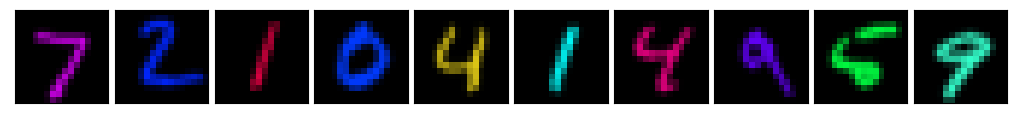

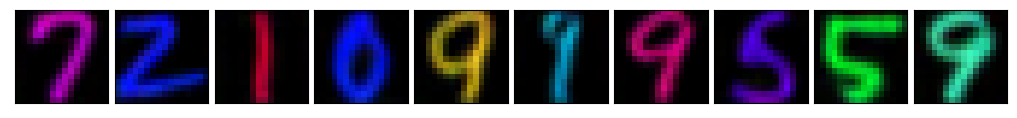

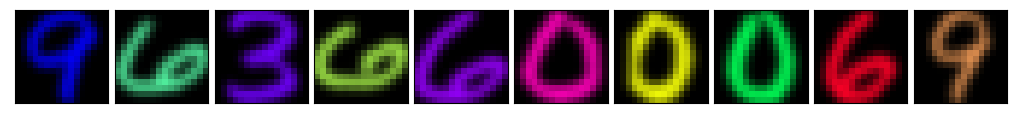

In [16]:
# NOT algorithm
for step in tqdm(range(MAX_STEPS)):
     # T optimization
    T.train(True); f.eval()
    for t_iter in range(T_ITERS):
        X = # <<< your code here >>>
        T_loss = # <<< your code here >>>
        T_opt.zero_grad(); T_loss.backward(); T_opt.step()

    # f optimization
    T.eval(); f.train(True)
    X, Y = # <<< your code here >>>
    f_loss = # <<< your code here >>>
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    if step % 200 == 0:
        clear_output(wait=True)
        print("Step", step)

        # The code for plotting the results
        with torch.no_grad():
            T_X_test_fixed = T(torch.tensor(X_test_fixed, device=DEVICE)).to('cpu')
        print('Mnist images X, mapped images T(X), unpaired USPS images Y')
        plot_images(X_test_fixed)
        plot_images(T_X_test_fixed)
        plot_images(Y_test_fixed)
        plt.show()

❔ After obtaining the results, think about the following questions:
- Do the output images resemble the shape/details/color of the input images (a.k.a. image content)?
- Does the map preserve the class of the digit during the translation?
- Does the quadratic cost turn to be a good choice for this pair of datasets? Yes/No? Why?

🔎 **Remark.** The quadratic cost is a good choice for certain pairs of datasets, e.g., see the experiments on RGB images in the Section 5.2 of the [NOT paper](https://arxiv.org/abs/2201.12220). However, it may not capture specific relations between the datasets, e.g., the digit class. To handle such cases, one may consider general OT costs, see the [General NOT](https://arxiv.org/abs/2205.15403) algorithm. This is a topic for a separate seminar.